## Tuning Parquet files

For high performance, Parquet requires a good schema and physical design. Let's look at 

* Data types
* Encodings
* And compressions.

### Parquet data types

Parquet has a complete type system.

**Physical data types** are the binary data types that Parquet stores data in:

- `BOOLEAN`: 1 bit boolean
- `INT32`: 32 bit signed ints
- `INT64`: 64 bit signed ints
- `FLOAT`: IEEE 32-bit floating point values
- `DOUBLE`: IEEE 64-bit floating point values
- `BYTE_ARRAY`: arbitrarily long byte arrays
- `FIXED_LEN_BYTE_ARRAY`: fixed length byte arrays

**Logical data types** are additional interpretations on top of the physical data types for outside representation and validation:

Numeric Types:

- `INT(bitWidth, isSigned)`: Signed/unsigned integers (8, 16, 32, 64 bits)
  - `INT8`, `INT16`, `INT32`, `INT64` (signed)
  - `UINT8`, `UINT16`, `UINT32`, `UINT64` (unsigned)
- `DECIMAL(precision, scale)`: Fixed-point decimal numbers (mapped to INT32, INT64, FIXED_LEN_BYTE_ARRAY)

String Types:

- `STRING`: UTF-8 encoded character strings
- `ENUM`: Enumerated string values
- `UUID`: 128-bit universally unique identifiers
- `JSON`: JSON-encoded strings

Temporal Types:

- `DATE`: Calendar date (days since Unix epoch)
- `TIME`: Time of day with microsecond or nanosecond precision
  - With/without timezone
- `TIMESTAMP`: Instant in time with microsecond or nanosecond precision
  - With/without timezone (UTC or local)
- `INTERVAL`: Time duration

Binary Types:

- `BSON`: Binary JSON format

Nested/Complex Types:

- `LIST`: Ordered collection of elements
- `MAP`: Key-value pairs
- `STRUCT`: Record with named fields (nested columns)

Parquet libraries will typically infer a working data type from the input data, but, for example, JSON has a much more elementary type system and you may need to "help" with the interpretation. 

### Sorting order

Sorting data by frequently queried columns (like `source` and `time`) improves compression and enables predicate pushdown during queries. 

To improve compression, Parquet applies run-length encoding and can apply delta encoding:

* **Run-length encoding** means that repeating values are stored as a tuple of (number of repetitions, value). Conceptually, if your values are "device_1", "device_1", "device_2", "device_2", the run-length encoding is (2, "device_1"), (2, "device_2").
* **Delta encoding** means that the difference between two values is stored. For example, if you have data coming into the system every second for a device, instead of storing each timestamp, only the initial timestamp and a sequence of 1000 (milliseconds) is stored. This way, you get many similar values that can be efficiently run-length encoded.

Predicate pushdown means that certain parts of files can be skipped during queries. If you sort by device, you can ideally just read the sections of the files with that device. 

Let's first read again the original events as they are, and then sort them by "source" (device) and time.

In [1]:
import daft
import pyarrow.parquet as pq
from pathlib import Path
from time import time
import matplotlib.pyplot as plt
import dateutil
import re

%reload_ext autoreload
%autoreload 2
from helpers import inspect, compare_sizes

events_data = daft.read_json('../data/input/events.jsonl').exclude('id')
files = events_data.write_parquet('../data/output/events')
events_parquet_path = Path(files.to_pydict()['path'][0])

events_parquet = pq.ParquetFile(events_parquet_path)
print(f"Base file size: {events_parquet_path.stat().st_size:,} bytes")

/Users/eickler/Documents/knee-deep-in-the-lake/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[00:00] 🗡️ 🐟 Json Scan: 1,337,981 rows out, 0 B bytes read | 🗡️ 🐟 Parquet Write: 1,337,981 rows in, 0 rows written, 0 B bytes written | 🗡️ 🐟 Commit Write: 1 rows in, 1 rows out

Base file size: 20,996,547 bytes


In [2]:
print("Sorting by device and time...")
events_data_sorted = events_data.sort([daft.col('source'), daft.col('time')])

files = events_data_sorted.write_parquet('../data/output/events_sorted')
events_parquet_path_sorted = Path(files.to_pydict()['path'][0])

events_parquet_sorted = pq.ParquetFile(events_parquet_path_sorted)
compare_sizes(events_parquet, "Original", events_parquet_sorted, "Sorted")

Sorting by device and time...
[00:00] 🗡️ 🐟 Json Scan: 1,337,981 rows out, 0 B bytes read | 🗡️ 🐟 Sort: 1,337,981 rows in, 1,337,981 rows out | 🗡️ 🐟 Parquet Write: 1,337,981 rows in, 0 rows written, 0 B bytes written | 🗡️ 🐟 Commit Write: 1 rows in, 1 rows out



,Column,Original Dict Size,Sorted Dict Size,Dict Size %,Original Data Size,Sorted Data Size,Data Size %
0,creationTime,747737,742310,99.27%,5774167,6033601,104.49%
1,source,78,78,100.00%,337964,169,0.05%
2,text,166388,164531,98.88%,9028294,8724254,96.63%
3,time,749190,743688,99.27%,5781246,6040160,104.48%
4,type,81,81,100.00%,73576,181637,246.87%


How can you explain the size differences? Verify your explanation using `parqeye` and `parquet-tools`. For example, to inspect the `source` column in more detail, use

```
parquet-tools inspect --row-group 0 --column-chunk 2 ….parquet | python3 -mjson.tool 
parquet-tools inspect --row-group 0 --column-chunk 2 --page 0 ….parquet | python3 -mjson.tool 
```

What do you think, is delta encoding efficient on events? Why or why not?

### Data modelling

In our example, events contain formatted log messages with a text and the ID of the work piece. 

```
Starting to work on workpiece 2024_9550021
Stop to work on workpiece 2024_9550021
```

This is a common approach, but for analytics, it would be much more efficient to separate the workpiece ID right away instead of first formatting it and then parsing it back. Let's split the log entry and add a column for the workpiece ID.

In [8]:
events_data_split = events_data.with_columns({
    "workpiece_year": daft.col("text").regexp_extract(r"workpiece\s+(\d+)_", 1).cast(daft.DataType.int32()),
    "workpiece_num": daft.col("text").regexp_extract(r"workpiece\s+\d+_(\d+)", 1).cast(daft.DataType.int64()),
    "text": daft.col("text").regexp_replace(r"work\s+.*$", "work")
}).sort([daft.col('source'), daft.col('time')])

start_time = time()
files = events_data_split.write_parquet('../data/output/events_split')
events_parquet_path_split = Path(files.to_pydict()['path'][0])
write_time = time() - start_time

events_parquet_split = pq.ParquetFile(events_parquet_path_split)
compare_sizes(events_parquet_sorted, "Sorted", events_parquet_split, "Split")
print(f"Write time (Snappy): {write_time:.2f}s")

[00:05] 🗡️ 🐟 Json Scan: 1,337,981 rows out, 0 B bytes read | 🗡️ 🐟 Project: 1,337,981 rows in, 1,337,981 rows out | 🗡️ 🐟 Sort: 1,337,981 rows in, 1,337,981 rows out | 🗡️ 🐟 Parquet Write: 1,337,981 rows in, 0 rows written, 0 B bytes written | 🗡️ 🐟 Commit Write: 1 rows in, 1 rows out



,Column,Sorted Dict Size,Split Dict Size,Dict Size %,Sorted Data Size,Split Data Size,Data Size %
0,creationTime,742310,742308,100.00%,6033601,6033598,100.00%
1,source,78,78,100.00%,169,169,100.00%
2,text,164531,97,0.06%,8724254,239280,2.74%
3,time,743688,743688,100.00%,6040160,6040160,100.00%
4,type,81,81,100.00%,181637,181329,99.83%
5,workpiece_num,0,679222,N/A,0,5103113,N/A
6,workpiece_year,0,24,N/A,0,25951,N/A


Write time (Snappy): 5.35s


### Compression

gzip can be used instead of snappy as compression.

In [10]:
start_time = time()
files = events_data_split.write_parquet('../data/output/events_gzip', compression="gzip")
events_parquet_path_gzip = Path(files.to_pydict()['path'][0])
gzip_time = time() - start_time

print(f"Snappy Size: {events_parquet_path_split.stat().st_size:,} bytes | Time: {write_time:.2f}s")
print(f"Gzip Size:   {events_parquet_path_gzip.stat().st_size:,} bytes | Time: {gzip_time:.2f}s")
print(f"Reduction vs Original: {events_parquet_path_gzip.stat().st_size/events_parquet_path.stat().st_size * 100:.2f}%")

[00:19] 🗡️ 🐟 Json Scan: 1,337,981 rows out, 0 B bytes read | 🗡️ 🐟 Project: 1,337,981 rows in, 1,337,981 rows out | 🗡️ 🐟 Sort: 1,337,981 rows in, 1,337,981 rows out | 🗡️ 🐟 Parquet Write: 1,337,981 rows in, 0 rows written, 0 B bytes written | 🗡️ 🐟 Commit Write: 1 rows in, 1 rows out

Snappy Size: 17,625,336 bytes | Time: 5.35s
Gzip Size:   9,867,755 bytes | Time: 19.43s
Reduction vs Original: 47.00%


Much better compression, but also quite some performance impact -- also for querying!

Note: If you use gzip on original JSON file, you will reach 23475269 bytes. So the optimized Parquet version is only 42% of the original file.

## Querying

Let's query the brandnew workpiece ID. 

Weekly Workpiece Production:
[00:04] 🗡️ 🐟 Json Scan: 1,337,981 rows out, 0 B bytes read | 🗡️ 🐟 Project: 1,337,981 rows in, 1,337,981 rows out | 🗡️ 🐟 Sort: 1,337,981 rows in, 1,337,981 rows out | 🗡️ 🐟 Project: 1,337,981 rows in, 1,337,981 rows out | 🗡️ 🐟 GroupedAggregate: 1,337,981 rows in, 50 rows out | 🗡️ 🐟 Sort: 50 rows in, 50 rows out



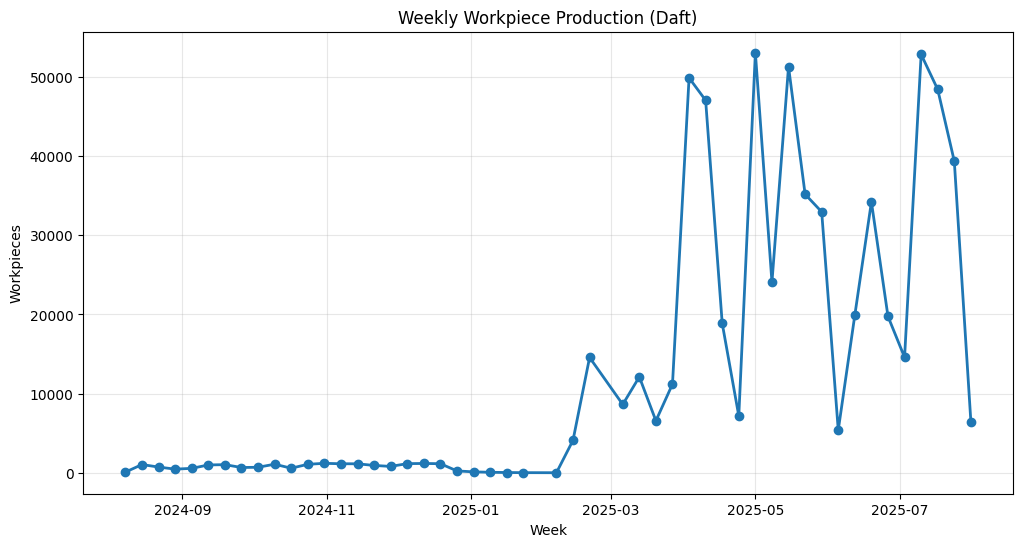

In [11]:
print("Weekly Workpiece Production:")

result = (
    events_data_split
    .with_column("week", daft.col("time").date_trunc("1 week"))
    .with_column("workpiece_id",
        daft.col("workpiece_year").cast(daft.DataType.string()) + "_" +
        daft.col("workpiece_num").cast(daft.DataType.string()))
    .groupby("week")
    .agg(daft.col("workpiece_id").count_distinct().alias("pieces_per_week"))
    .sort("week")
    .to_pandas()
)

# Visualize
plt.figure(figsize=(12, 6))
plt.plot(result['week'], result['pieces_per_week'], marker='o', linewidth=2)
plt.xlabel('Week')
plt.ylabel('Workpieces')
plt.title('Weekly Workpiece Production (Daft)')
plt.grid(True, alpha=0.3)
plt.show()

## Summary


In a [previous version of the notebook](https://github.com/Cumulocity-IoT/knee-deep-in-the-lake/blob/bfdf6f0b4d6fe897247e6cb0ff83b26d79738363/01_parquet/02_tuning.ipynb), we used PyArrow for writing the Parquet files. PyArrow requires quite some handholding to write efficient Parquet files, more than, for example, Daft and the Java implementations. If you use other libraries, verify that the schema and the encodings are efficient using Parquet inspection tools.

...

PyArrow's schema discovery does a "quick and dirty" job in discovering the schema in the source data and blindly applies dictionaries everywhere, but does not even consistently use them. The Java implementation is a little bit smarter, but with the very basic type system of JSON as input, there is only so much that you can do automatically. So for analytics on larger scale, some tuning is needed -- we'll get back to that in the third module.

Other insights: 
* Parquet uses only a few physical types in the column storage layer; all other standard types are applied on top.
* "Snappy" compression seems a good tradeoff between disk and CPU resource usage.
* Besides the correct implementation and encoding of data types, there are also a number of other tuning parameters, like row group and data page size. Parquet [recommends](https://parquet.apache.org/docs/file-format/configurations/) row groups at 1GB size and data page sizes at 8KB. Here are [some benchmarks](https://developer.nvidia.com/blog/encoding-and-compression-guide-for-parquet-string-data-using-rapids/).



Note: You can view more details on dictionaries and data pages using `parquet-tools`. For example, to see `source` (Column 2), and to view its dictionary (usually in Page 0):

```
parquet-tools inspect --row-group 0 --column-chunk 2 events.parquet | python3 -mjson.tool 
parquet-tools inspect --row-group 0 --column-chunk 2 --page 0 events.parquet | python3 -mjson.tool 
```


